In [63]:
#Directory Work
import os
import glob

#Data Work
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns
from IPython.display import Image

#Forecasting
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Optimization Model
from pyomo.environ import *
from pyomo.opt import SolverFactory

# 1. Exploratory Data Analysis (EDA)

In [64]:
#define paths
path_base=os.getcwd()
path_data="/case_study_data/"

## 1.1 Import customer data

### 1.1.1 customer 1

In [65]:
df_cust1=pd.read_csv(path_base+path_data+"consumer_01.csv", index_col=0, parse_dates=True,infer_datetime_format=True)

In [66]:
df_cust1

,meter_id,energy_heat_kwh,volume_flow_m3,current_power,t_supply,t_return
time_rounded,,,,,,
2018-01-03 00:00:00+00:00,1,3042.9,66.1,3.0,74.7,34.1
2018-01-03 01:00:00+00:00,1,3046.7,66.1,3.8,74.8,34.1
2018-01-03 02:00:00+00:00,1,3049.8,66.2,3.1,74.8,34.1
2018-01-03 03:00:00+00:00,1,3052.8,66.3,3.0,74.8,34.1
2018-01-03 04:00:00+00:00,1,3056.5,66.4,3.7,74.7,34.1
...,...,...,...,...,...,...
2020-12-31 18:00:00+00:00,1,68250.0,1733.2,2.9,71.0,36.2
2020-12-31 19:00:00+00:00,1,68254.3,1733.2,4.3,71.0,36.2
2020-12-31 20:00:00+00:00,1,68258.2,1733.3,3.9,71.0,36.2


Observations:

1. energy_heat_kwh is a cumulative column
    - energy_heat_kwh[t-1] + current_power [t] = energy_heat_kwh[t]
    - meter reading
    <br/><br/>
2. volume_flow_m³ is also a cumulative column
<br/><br/>
3. current_power != V * rho * cp * (T_supply - T_return)
    - e.g. 2018-01-03 02:00:
    - current_power = 3.1kWh
    - [(66.2m³/h -66.1m³/h)/3,600s/h]* 997 kg/m³ * 4.183 kJ/(kg*K) * (74.8K -34.1K) = 4,71kW
    - 4.71kW * 1h = 4.71kWh != current_power
    

In [67]:
#Create new column "delta_volume"
df_cust1["delta_volume"]=df_cust1["volume_flow_m3"].diff()
df_cust1.fillna(value=0,inplace=True)

In [68]:
#Create new column "calculated_heat_kwh"
df_cust1["calculated_heat_kwh"]=(df_cust1["delta_volume"]/3600)*997*4.183*(df_cust1["t_supply"]-df_cust1["t_return"])

In [69]:
#Create Error column
df_cust1["heat_error_kwh"]=df_cust1["current_power"]-df_cust1["calculated_heat_kwh"]
df_cust1

,meter_id,energy_heat_kwh,volume_flow_m3,current_power,t_supply,t_return,delta_volume,calculated_heat_kwh,heat_error_kwh
time_rounded,,,,,,,,,
2018-01-03 00:00:00+00:00,1,3042.9,66.1,3.0,74.7,34.1,0.0,0.000000,3.000000
2018-01-03 01:00:00+00:00,1,3046.7,66.1,3.8,74.8,34.1,0.0,0.000000,3.800000
2018-01-03 02:00:00+00:00,1,3049.8,66.2,3.1,74.8,34.1,0.1,4.714927,-1.614927
2018-01-03 03:00:00+00:00,1,3052.8,66.3,3.0,74.8,34.1,0.1,4.714927,-1.714927
2018-01-03 04:00:00+00:00,1,3056.5,66.4,3.7,74.7,34.1,0.1,4.703342,-1.003342
...,...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00+00:00,1,68250.0,1733.2,2.9,71.0,36.2,0.1,4.031436,-1.131436
2020-12-31 19:00:00+00:00,1,68254.3,1733.2,4.3,71.0,36.2,0.0,0.000000,4.300000
2020-12-31 20:00:00+00:00,1,68258.2,1733.3,3.9,71.0,36.2,0.1,4.031436,-0.131436


In [70]:
df_cust1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26255 entries, 2018-01-03 00:00:00+00:00 to 2020-12-31 22:00:00+00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   meter_id             26255 non-null  int64  
 1   energy_heat_kwh      26255 non-null  float64
 2   volume_flow_m3       26255 non-null  float64
 3   current_power        26255 non-null  float64
 4   t_supply             26255 non-null  float64
 5   t_return             26255 non-null  float64
 6   delta_volume         26255 non-null  float64
 7   calculated_heat_kwh  26255 non-null  float64
 8   heat_error_kwh       26255 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.0 MB


In [71]:
df_cust1.isna().sum()

meter_id               0
energy_heat_kwh        0
volume_flow_m3         0
current_power          0
t_supply               0
t_return               0
delta_volume           0
calculated_heat_kwh    0
heat_error_kwh         0
dtype: int64

In [73]:
#df_cust1.describe()

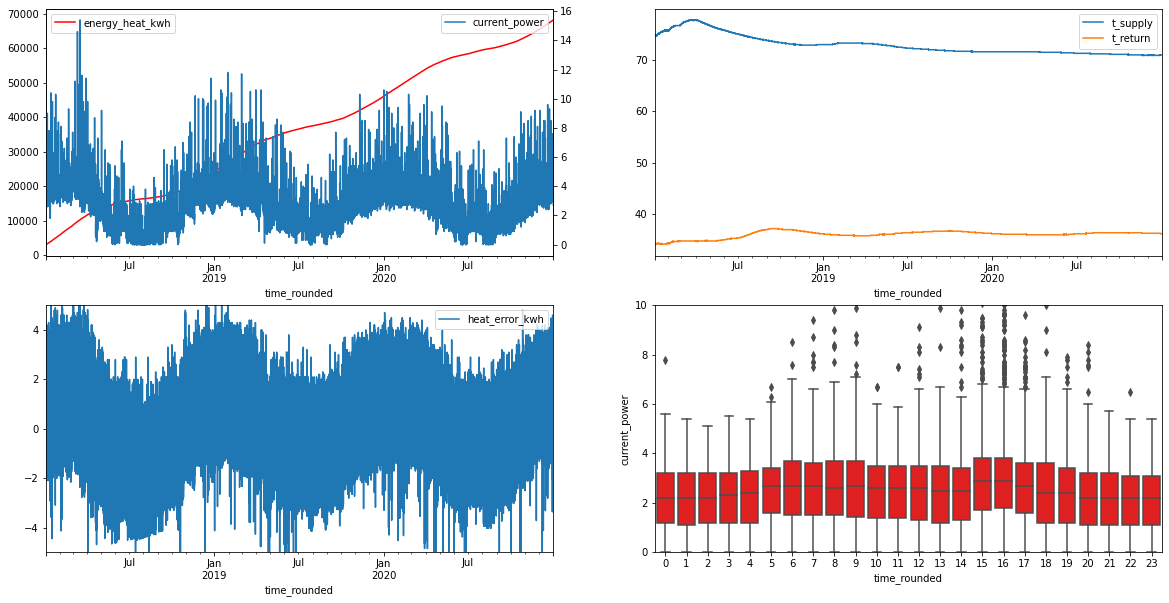

In [74]:
#plot relevant data
fig,axs=plt.subplots(2,2)
#Figure 1
ax1=df_cust1["energy_heat_kwh"].plot(ax=axs[0,0],legend=True,color='r')
ax2=ax1.twinx()
df_cust1["current_power"].plot(ax=ax2,legend=True)

#Figure 2
df_cust1[['t_supply','t_return']].plot(ax=axs[0,1],legend=True)

#Figure 3
ax3=df_cust1["heat_error_kwh"].plot(ax=axs[1,0],legend=True)
ax3.set_ylim([-5,5])

#Figure 4
ax4=sns.boxplot(x=df_cust1.index.hour,y=df_cust1['current_power'],color="red",ax=axs[1,1])
ax4.set_ylim([0,10]);

Observations:

1. t range nearly constant 
    - no difference between summer and winter operation

2. error follows seasonal pattern

3. realistic shape of current_power curve 
    - yearly pattern
    - daily pattern (morning, afternoon) 

Conclusions:

1. current_power as base for demand values in the model
2. no differenciation between winter and summer
3. typical private household profile

### 1.1.2 customer 17

In [75]:
df_cust17=pd.read_csv(path_base+path_data+"consumer_17.csv", index_col=0, parse_dates=True,infer_datetime_format=True)

In [76]:
#Create new column "delta_volume"
df_cust17["delta_volume"]=df_cust17["volume_flow_m3"].diff()
df_cust17.fillna(value=0,inplace=True)

In [77]:
#Create new column "calculated_heat_kwh"
df_cust17["calculated_heat_kwh"]=(df_cust17["delta_volume"]/3600)*997*4.183*(df_cust17["t_supply"]-df_cust17["t_return"])

In [78]:
#Create Error column
df_cust17["heat_error_kwh"]=df_cust17["current_power"]-df_cust17["calculated_heat_kwh"]
df_cust17

,meter_id,energy_heat_kwh,volume_flow_m3,current_power,t_supply,t_return,delta_volume,calculated_heat_kwh,heat_error_kwh
time_rounded,,,,,,,,,
2018-01-03 00:00:00+00:00,17,56531.7,1836.9,2.2,62.0,35.0,0.0,0.000000,2.200000
2018-01-03 01:00:00+00:00,17,56534.6,1837.0,2.9,62.0,35.0,0.1,3.127838,-0.227838
2018-01-03 02:00:00+00:00,17,56537.6,1837.1,3.0,62.0,35.0,0.1,3.127838,-0.127838
2018-01-03 03:00:00+00:00,17,56540.6,1837.2,3.0,62.0,35.0,0.1,3.127838,-0.127838
2018-01-03 04:00:00+00:00,17,56544.4,1837.3,3.8,62.0,35.0,0.1,3.127838,0.672162
...,...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00+00:00,17,108788.7,3660.9,2.1,62.2,36.1,0.1,3.023577,-0.923577
2020-12-31 19:00:00+00:00,17,108789.9,3660.9,1.2,62.2,36.1,0.0,0.000000,1.200000
2020-12-31 20:00:00+00:00,17,108795.1,3661.0,5.2,62.2,36.1,0.1,3.023577,2.176423


In [79]:
df_cust17.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26255 entries, 2018-01-03 00:00:00+00:00 to 2020-12-31 22:00:00+00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   meter_id             26255 non-null  int64  
 1   energy_heat_kwh      26255 non-null  float64
 2   volume_flow_m3       26255 non-null  float64
 3   current_power        26255 non-null  float64
 4   t_supply             26255 non-null  float64
 5   t_return             26255 non-null  float64
 6   delta_volume         26255 non-null  float64
 7   calculated_heat_kwh  26255 non-null  float64
 8   heat_error_kwh       26255 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.0 MB


In [80]:
#df_cust17.describe()

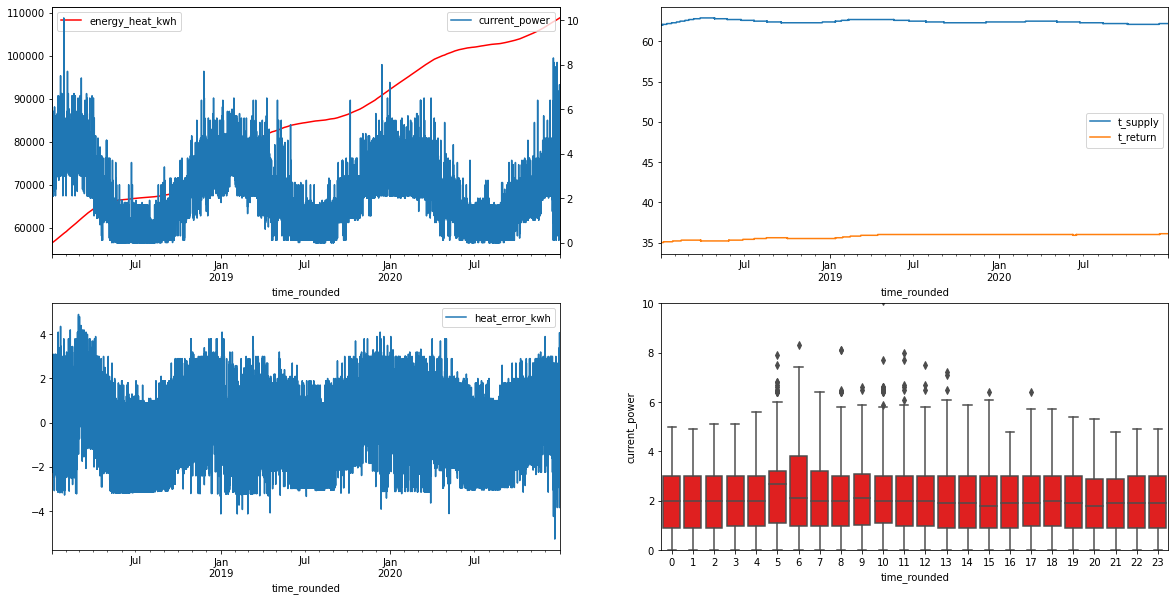

In [81]:
#plot relevant data
fig,axs=plt.subplots(2,2)
#Figure 1
ax1=df_cust17["energy_heat_kwh"].plot(ax=axs[0,0],legend=True,color='r')
ax2=ax1.twinx()
df_cust17["current_power"].plot(ax=ax2,legend=True)

#Figure 2
df_cust17[['t_supply','t_return']].plot(ax=axs[0,1],legend=True)

#Figure 3
df_cust17["heat_error_kwh"].plot(ax=axs[1,0],legend=True)

#Figure 4
ax3=sns.boxplot(x=df_cust17.index.hour,y=df_cust17['current_power'],color="red",ax=axs[1,1])
ax3.set_ylim([0,10]);

Observations:

1. t range nearly constant, but lower than costumer 1
    - no difference between summer and winter operation

2. error follows the seasonal pattern

3. realistic shape of current_power curve 
    - yearly pattern
    - daily pattern (just morning and lunch time) 

4. single current_power outliers and peak demand at 5am

Conclusions:

1. current_power as base for demand values in the model
2. no differenciation between winter and summer
3. school profile (?)

### 1.1.3 customer 30

In [82]:
df_cust30=pd.read_csv(path_base+path_data+"consumer_30.csv", index_col=0, parse_dates=True,infer_datetime_format=True)

In [83]:
#Create new column "delta_volume"
df_cust30["delta_volume"]=df_cust30["volume_flow_m3"].diff()
df_cust30.fillna(value=0,inplace=True)

In [84]:
#Create new column "calculated_heat_kwh"
df_cust30["calculated_heat_kwh"]=(df_cust30["delta_volume"]/3600)*997*4.183*(df_cust30["t_supply"]-df_cust30["t_return"])

In [85]:
#Create Error column
df_cust30["heat_error_kwh"]=df_cust30["current_power"]-df_cust30["calculated_heat_kwh"]
df_cust30

,meter_id,energy_heat_kwh,volume_flow_m3,current_power,t_supply,t_return,delta_volume,calculated_heat_kwh,heat_error_kwh
time_rounded,,,,,,,,,
2018-01-03 00:00:00+00:00,30,6409.7,145.8,3.0,66.4,27.7,0.0,0.000000,3.000000
2018-01-03 01:00:00+00:00,30,6411.9,145.9,2.2,66.4,27.7,0.1,4.483235,-2.283235
2018-01-03 02:00:00+00:00,30,6414.7,145.9,2.8,66.4,27.7,0.0,0.000000,2.800000
2018-01-03 03:00:00+00:00,30,6417.7,146.0,3.0,66.4,27.7,0.1,4.483235,-1.483235
2018-01-03 04:00:00+00:00,30,6420.7,146.0,3.0,66.4,27.7,0.0,0.000000,3.000000
...,...,...,...,...,...,...,...,...,...
2020-12-31 18:00:00+00:00,30,50609.6,1178.4,3.4,66.8,29.0,0.1,4.378974,-0.978974
2020-12-31 19:00:00+00:00,30,50615.3,1178.5,5.7,66.8,29.0,0.1,4.378974,1.321026
2020-12-31 20:00:00+00:00,30,50619.2,1178.6,3.9,66.8,29.0,0.1,4.378974,-0.478974


In [86]:
df_cust30.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26255 entries, 2018-01-03 00:00:00+00:00 to 2020-12-31 22:00:00+00:00
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   meter_id             26255 non-null  int64  
 1   energy_heat_kwh      26255 non-null  float64
 2   volume_flow_m3       26255 non-null  float64
 3   current_power        26255 non-null  float64
 4   t_supply             26255 non-null  float64
 5   t_return             26255 non-null  float64
 6   delta_volume         26255 non-null  float64
 7   calculated_heat_kwh  26255 non-null  float64
 8   heat_error_kwh       26255 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.0 MB


In [87]:
#df_cust30.describe()

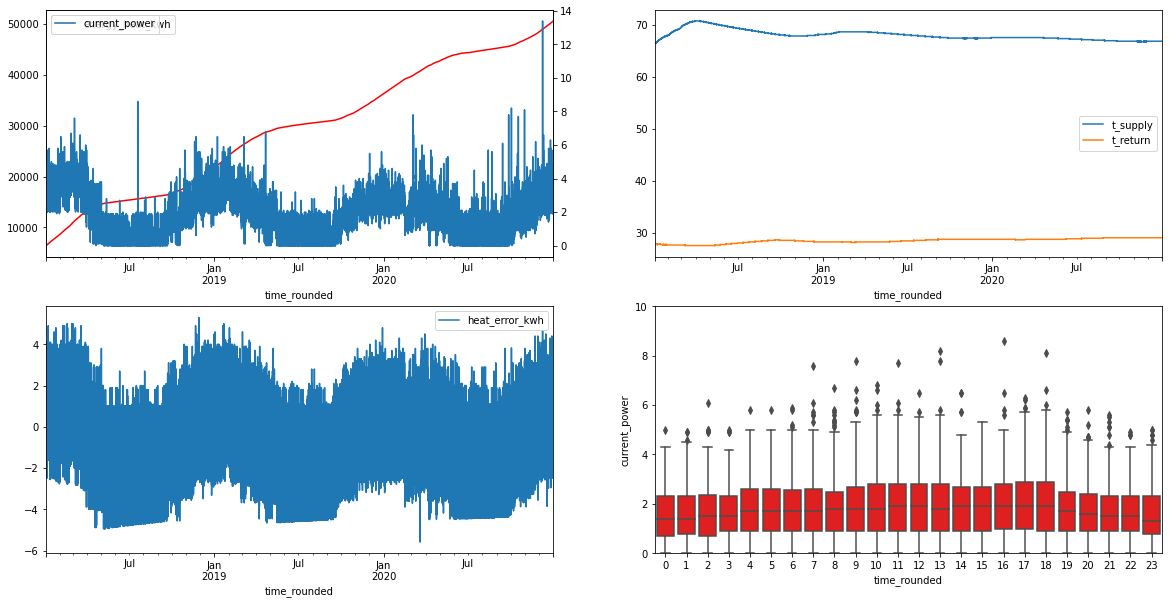

In [88]:
#plot relevant data
fig,axs=plt.subplots(2,2)
#Figure 1
ax1=df_cust30["energy_heat_kwh"].plot(ax=axs[0,0],legend=True,color='r')
ax2=ax1.twinx()
df_cust30["current_power"].plot(ax=ax2,legend=True)

#Figure 2
df_cust30[['t_supply','t_return']].plot(ax=axs[0,1],legend=True)

#Figure 3
df_cust30["heat_error_kwh"].plot(ax=axs[1,0],legend=True)

#Figure 4
ax3=sns.boxplot(x=df_cust30.index.hour,y=df_cust30['current_power'],color="red",ax=axs[1,1])
ax3.set_ylim([0,10]);

Observations:

1. t range nearly constant 
    - no difference between summer and winter operation

2. error follows seasonal pattern

3. realistic shape of current_power curve 
    - yearly pattern
    - daily pattern (morning till evening higher power values) 
 
4. single current_power outliers

Conclusions:

1. current_power as base for demand values in the model
2. no differenciation between winter and summer
3. typical company/bureau profile

## 1.2 Import heat production data

In [89]:
df_heat=pd.read_csv(path_base+path_data+"heat_production.csv", index_col=0, parse_dates=True,infer_datetime_format=True)
df_heat

,power_hp,power_solarthermic,power_waste_heat
time_rounded,,,
2018-01-03 00:00:00+00:00,53.735831,45.326337,61.544772
2018-01-03 01:00:00+00:00,54.185500,19.320131,60.655277
2018-01-03 02:00:00+00:00,62.793942,42.674275,51.189670
2018-01-03 03:00:00+00:00,60.508424,1.298309,56.385032
2018-01-03 04:00:00+00:00,61.167968,41.506088,48.524854
...,...,...,...
2020-12-31 18:00:00+00:00,51.396621,2.666453,63.987349
2020-12-31 19:00:00+00:00,51.422443,30.031520,47.374827
2020-12-31 20:00:00+00:00,61.086980,8.511240,61.884209


In [90]:
df_heat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26255 entries, 2018-01-03 00:00:00+00:00 to 2020-12-31 22:00:00+00:00
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   power_hp            26255 non-null  float64
 1   power_solarthermic  26255 non-null  float64
 2   power_waste_heat    26255 non-null  float64
dtypes: float64(3)
memory usage: 820.5 KB


In [91]:
df_heat.isna().sum()

power_hp              0
power_solarthermic    0
power_waste_heat      0
dtype: int64

In [92]:
df_heat.describe()

,power_hp,power_solarthermic,power_waste_heat
count,26255.000000,26255.000000,26255.000000
mean,38.004486,19.056348,38.031200
std,22.633279,17.090677,23.569196
min,3.198754,0.000822,2.858502
25%,16.369772,5.807472,16.218208
50%,35.927512,13.116345,35.333107
75%,56.675777,28.443930,55.867663
max,125.603136,104.217065,144.530605


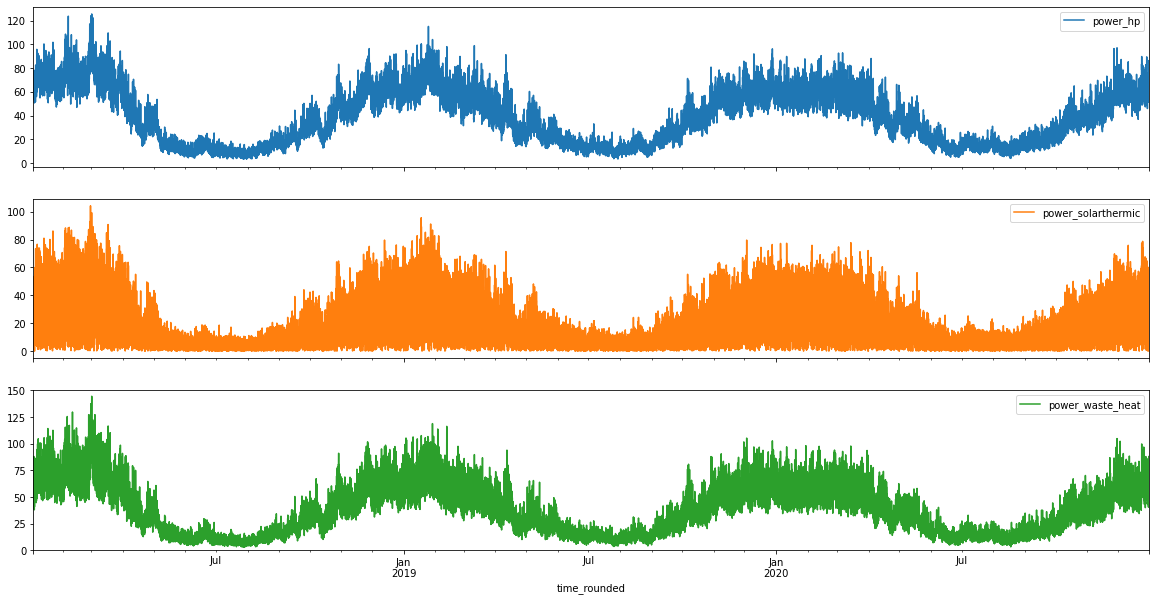

In [93]:
#Plot data
#fix,axs=plt.subplots(ncols=3)

#Figure 1
df_heat.plot(legend=True,subplots=True)
plt.ylim([0,150]);

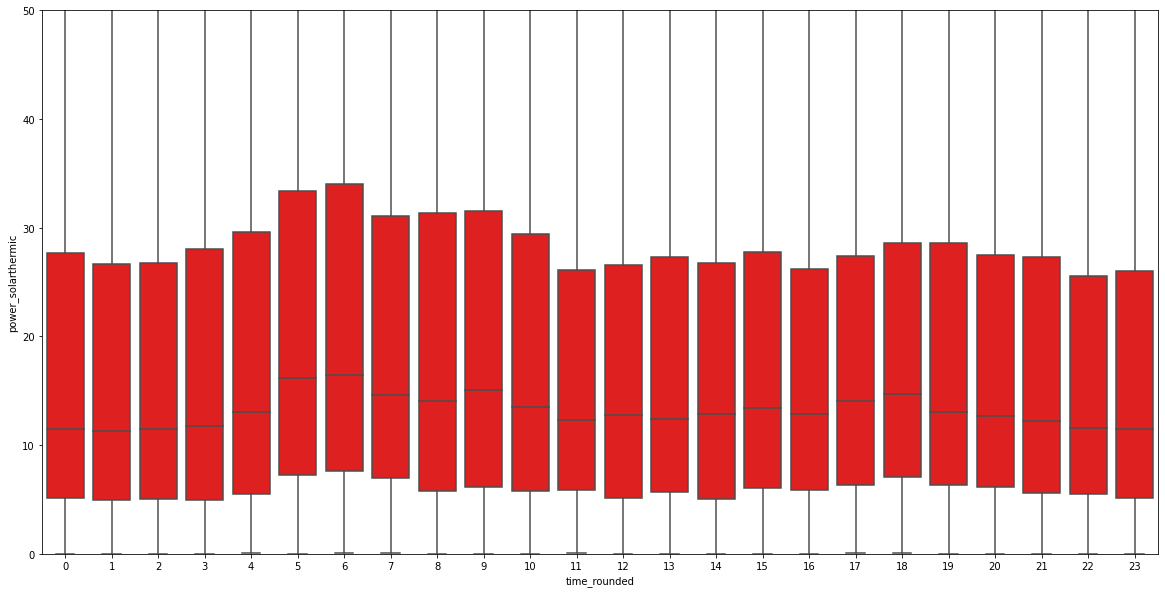

In [94]:
#Examine solarthermic heat generation per hour
ax=sns.boxplot(x=df_cust1.index.hour,y=df_heat['power_solarthermic'],color="red")
ax.set_ylim([0,50]);

Observations:

1. heatpump and wasteheat scheduled in the same operation mode
    - same min, median, max etc.
<br>
2. solarthermic power is not logical
    - supplying heat in dark hours
    - peak generation in winter months

## 1.3. Conclusions and next steps

1. There are different profiles of customers
    - it totally makes sense to cluster them and provide individual demand forecasts with machine learning per cluster based on the historical data (by k-Means-clustering for example https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering)
    - for simplifying reasons: sum up all customers to one single demand time series
  


2. There are different temperature levels depending on the customer
    - different customer needs lead to different temperatures in customer circuis
    - low demand leads to higher return temperatures
    - the higher the supply temperature the "earlier" the customer appears in the heat circuit (the nearer the customer is to the generation assets)
    
3. There is an seasonal pattern in the error between calculated heat and current_power
    - to get a running model here it´s appropriate to take the current_power values as a demand of the customers


4. Instanciate a state_solarthermic time series based on the sunshine duration per hour data
    - download pv generation data from smard.de

# 2. Feature Engineering

## 2.1 Sum up "current_power" of all customers

In [95]:
consumer_files=glob.glob(path_base+path_data+'consumer*')

In [33]:
#Sum "current power"
df_cust=pd.DataFrame([])
value_check=0
i=0
for consumer in consumer_files:
    #read data
    df=pd.read_csv(consumer, index_col=0, parse_dates=True,infer_datetime_format=True)
    #Concatenate
    df_cust=pd.concat([df_cust,df[['current_power']]]).groupby('time_rounded').sum()
    i+=1
    value_check=value_check+df['current_power'][0]
    #print(i)
    print(value_check)

3.0
7.5
9.5
14.4
18.2
20.8
23.1
24.1
26.0
27.9
31.799999999999997
33.8
35.8
36.8
43.099999999999994
43.199999999999996
45.4
46.4
48.5
50.5
54.6
58.5
60.7
62.7
68.3
71.39999999999999
74.19999999999999
77.99999999999999
81.89999999999999
84.89999999999999


In [96]:
#Change column  name
df_cust=df_cust.rename(columns={"current_power":"demand_cust"})
df_cust

,demand_cust
time_rounded,
2018-01-03 00:00:00+00:00,84.9
2018-01-03 01:00:00+00:00,80.7
2018-01-03 02:00:00+00:00,83.0
2018-01-03 03:00:00+00:00,83.5
2018-01-03 04:00:00+00:00,88.6
...,...
2020-12-31 18:00:00+00:00,80.6
2020-12-31 19:00:00+00:00,82.9
2020-12-31 20:00:00+00:00,81.4


<AxesSubplot:xlabel='time_rounded'>

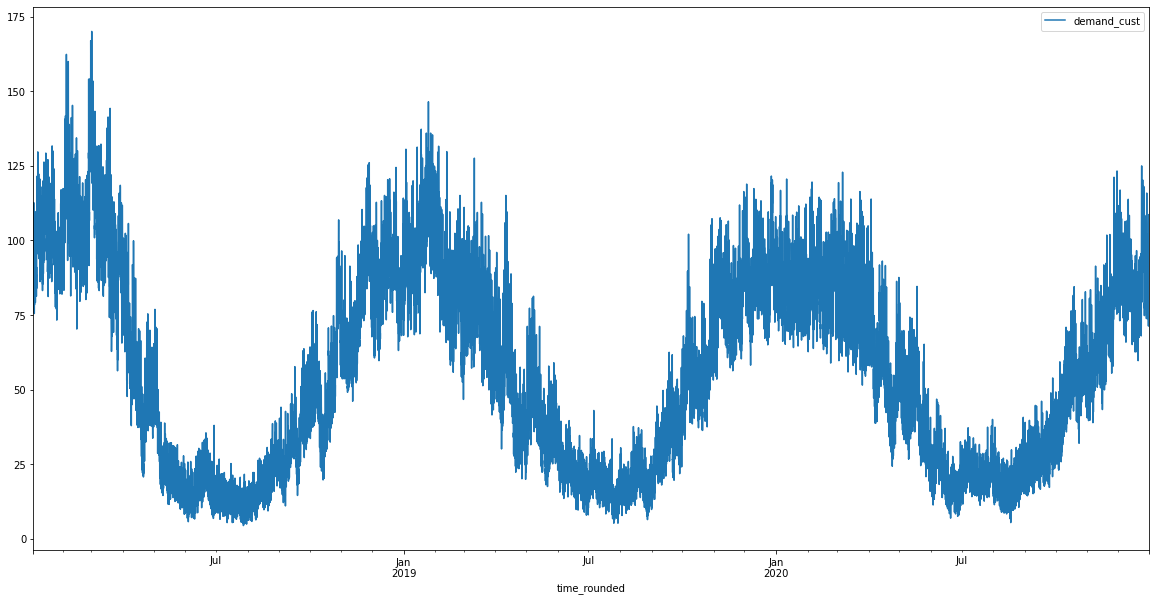

In [97]:
df_cust.plot()

## 2.2 edit solarthermic column

In [98]:
#load pv data smard.de
df_smard=pd.read_excel(path_base+path_data+"Prognostizierte_Erzeugung_201801030000_202012312359_Stunde.xlsx", header=9)

C:\Users\frost\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [99]:
#delete last hour
df_smard_edit=df_smard[:-1][['Photovoltaik [MWh]']]
#set index to df_heat_index
df_smard_edit=df_smard_edit.set_index(df_heat.index)
df_smard_edit

,Photovoltaik [MWh]
time_rounded,
2018-01-03 00:00:00+00:00,0.0
2018-01-03 01:00:00+00:00,0.0
2018-01-03 02:00:00+00:00,0.0
2018-01-03 03:00:00+00:00,0.0
2018-01-03 04:00:00+00:00,0.0
...,...
2020-12-31 18:00:00+00:00,0.0
2020-12-31 19:00:00+00:00,0.0
2020-12-31 20:00:00+00:00,0.0


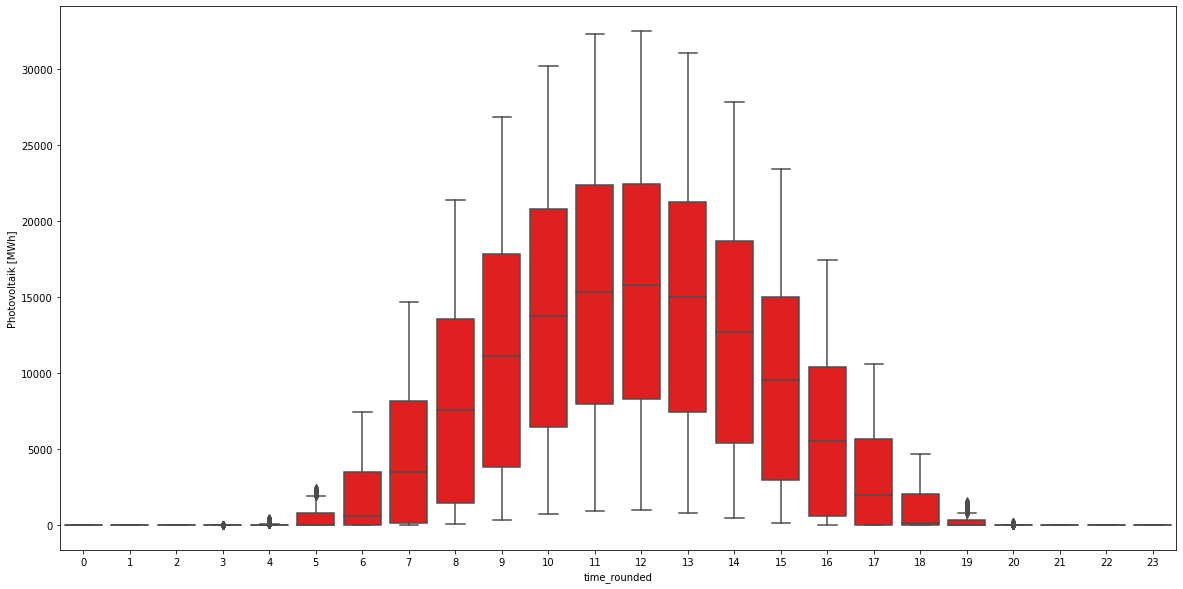

In [100]:
#Typical Solarthermic Production Pattern
sns.boxplot(x=df_smard_edit.index.hour,y=df_smard_edit['Photovoltaik [MWh]'],color="red");

In [101]:
#adapt PV production cyclus to solarthermic cyclus
df_heat['power_solarthermic_edit']=np.where(df_smard_edit['Photovoltaik [MWh]']>0, df_heat['power_solarthermic'],0)

In [102]:
df_heat.head(40)

,power_hp,power_solarthermic,power_waste_heat,power_solarthermic_edit
time_rounded,,,,
2018-01-03 00:00:00+00:00,53.735831,45.326337,61.544772,0.000000
2018-01-03 01:00:00+00:00,54.185500,19.320131,60.655277,0.000000
2018-01-03 02:00:00+00:00,62.793942,42.674275,51.189670,0.000000
2018-01-03 03:00:00+00:00,60.508424,1.298309,56.385032,0.000000
2018-01-03 04:00:00+00:00,61.167968,41.506088,48.524854,0.000000
2018-01-03 05:00:00+00:00,67.771682,15.096256,53.892003,0.000000
2018-01-03 06:00:00+00:00,61.478731,17.268716,81.684919,0.000000
2018-01-03 07:00:00+00:00,68.703673,17.681404,51.735728,0.000000
2018-01-03 08:00:00+00:00,70.492978,34.923079,53.199549,34.923079


## 2.3. combine dataframes

In [103]:
df_all=pd.concat([df_heat,df_cust],axis=1)

In [104]:
df_all

,power_hp,power_solarthermic,power_waste_heat,power_solarthermic_edit,demand_cust
time_rounded,,,,,
2018-01-03 00:00:00+00:00,53.735831,45.326337,61.544772,0.0,84.9
2018-01-03 01:00:00+00:00,54.185500,19.320131,60.655277,0.0,80.7
2018-01-03 02:00:00+00:00,62.793942,42.674275,51.189670,0.0,83.0
2018-01-03 03:00:00+00:00,60.508424,1.298309,56.385032,0.0,83.5
2018-01-03 04:00:00+00:00,61.167968,41.506088,48.524854,0.0,88.6
...,...,...,...,...,...
2020-12-31 18:00:00+00:00,51.396621,2.666453,63.987349,0.0,80.6
2020-12-31 19:00:00+00:00,51.422443,30.031520,47.374827,0.0,82.9
2020-12-31 20:00:00+00:00,61.086980,8.511240,61.884209,0.0,81.4


In [105]:
sum_power=(df_all[['power_hp','power_solarthermic_edit','power_waste_heat']].sum()).sum()
sum_power

2258957.968929876

In [106]:
sum_demand=df_all[['demand_cust']].sum()
sum_demand

demand_cust    1424651.6
dtype: float64

In [107]:
df_all['power_sum']=df_all['power_hp']+df_all['power_solarthermic_edit']+df_all['power_waste_heat']
df_all

,power_hp,power_solarthermic,power_waste_heat,power_solarthermic_edit,demand_cust,power_sum
time_rounded,,,,,,
2018-01-03 00:00:00+00:00,53.735831,45.326337,61.544772,0.0,84.9,115.280602
2018-01-03 01:00:00+00:00,54.185500,19.320131,60.655277,0.0,80.7,114.840777
2018-01-03 02:00:00+00:00,62.793942,42.674275,51.189670,0.0,83.0,113.983612
2018-01-03 03:00:00+00:00,60.508424,1.298309,56.385032,0.0,83.5,116.893456
2018-01-03 04:00:00+00:00,61.167968,41.506088,48.524854,0.0,88.6,109.692822
...,...,...,...,...,...,...
2020-12-31 18:00:00+00:00,51.396621,2.666453,63.987349,0.0,80.6,115.383970
2020-12-31 19:00:00+00:00,51.422443,30.031520,47.374827,0.0,82.9,98.797270
2020-12-31 20:00:00+00:00,61.086980,8.511240,61.884209,0.0,81.4,122.971189


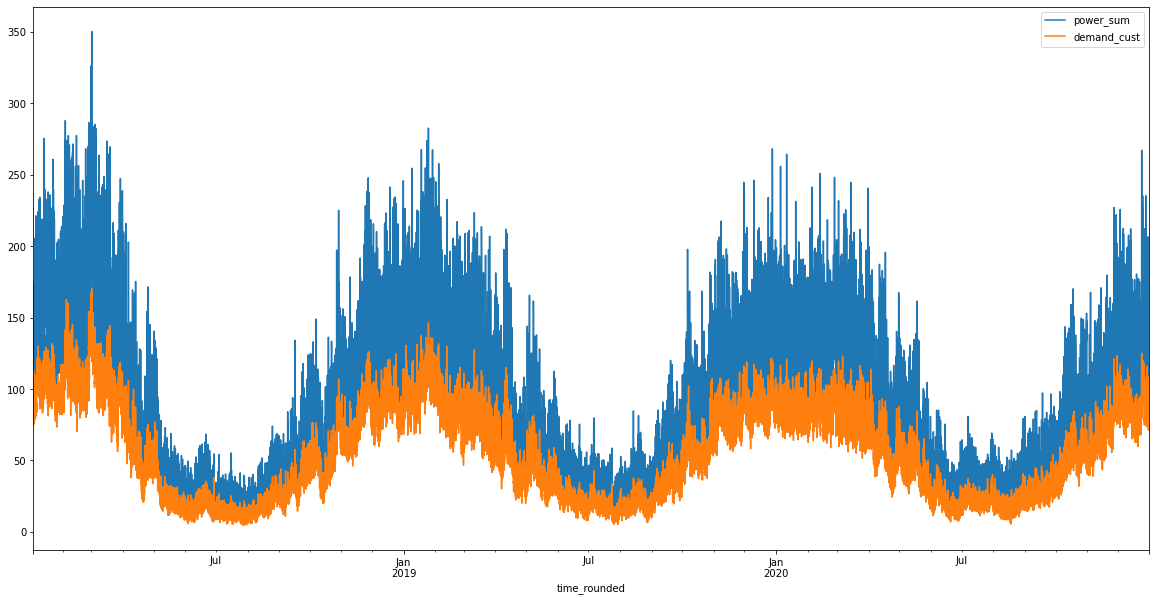

In [108]:
df_all[['power_sum','demand_cust']].plot();

Observations:
1. generated heat much higher than consumer demand
    - losses?


# 3. PyOMO Optimization Model

## 3.1. Framework Conditions

1. Duration
    - 1 week: Monday 08.01.2018 00:00 - Sunday 14.01.2018 23:00
    
2. Demand of customers needs to be satisfy every hour
    - without heat storage (first model)
    - with heat storage (second model) --> should be flatten the generation peaks!

3. heat generation assets are dependent from parameters/time series:
    - CO2 price
    - Power price
    - Garbage Price
    - Efficiency ratio
    - sunshine duration
    - Min/Max Power Limits

4. neglect heat losses
5. punish heat generation peaks

## 3.2. Modell Schema

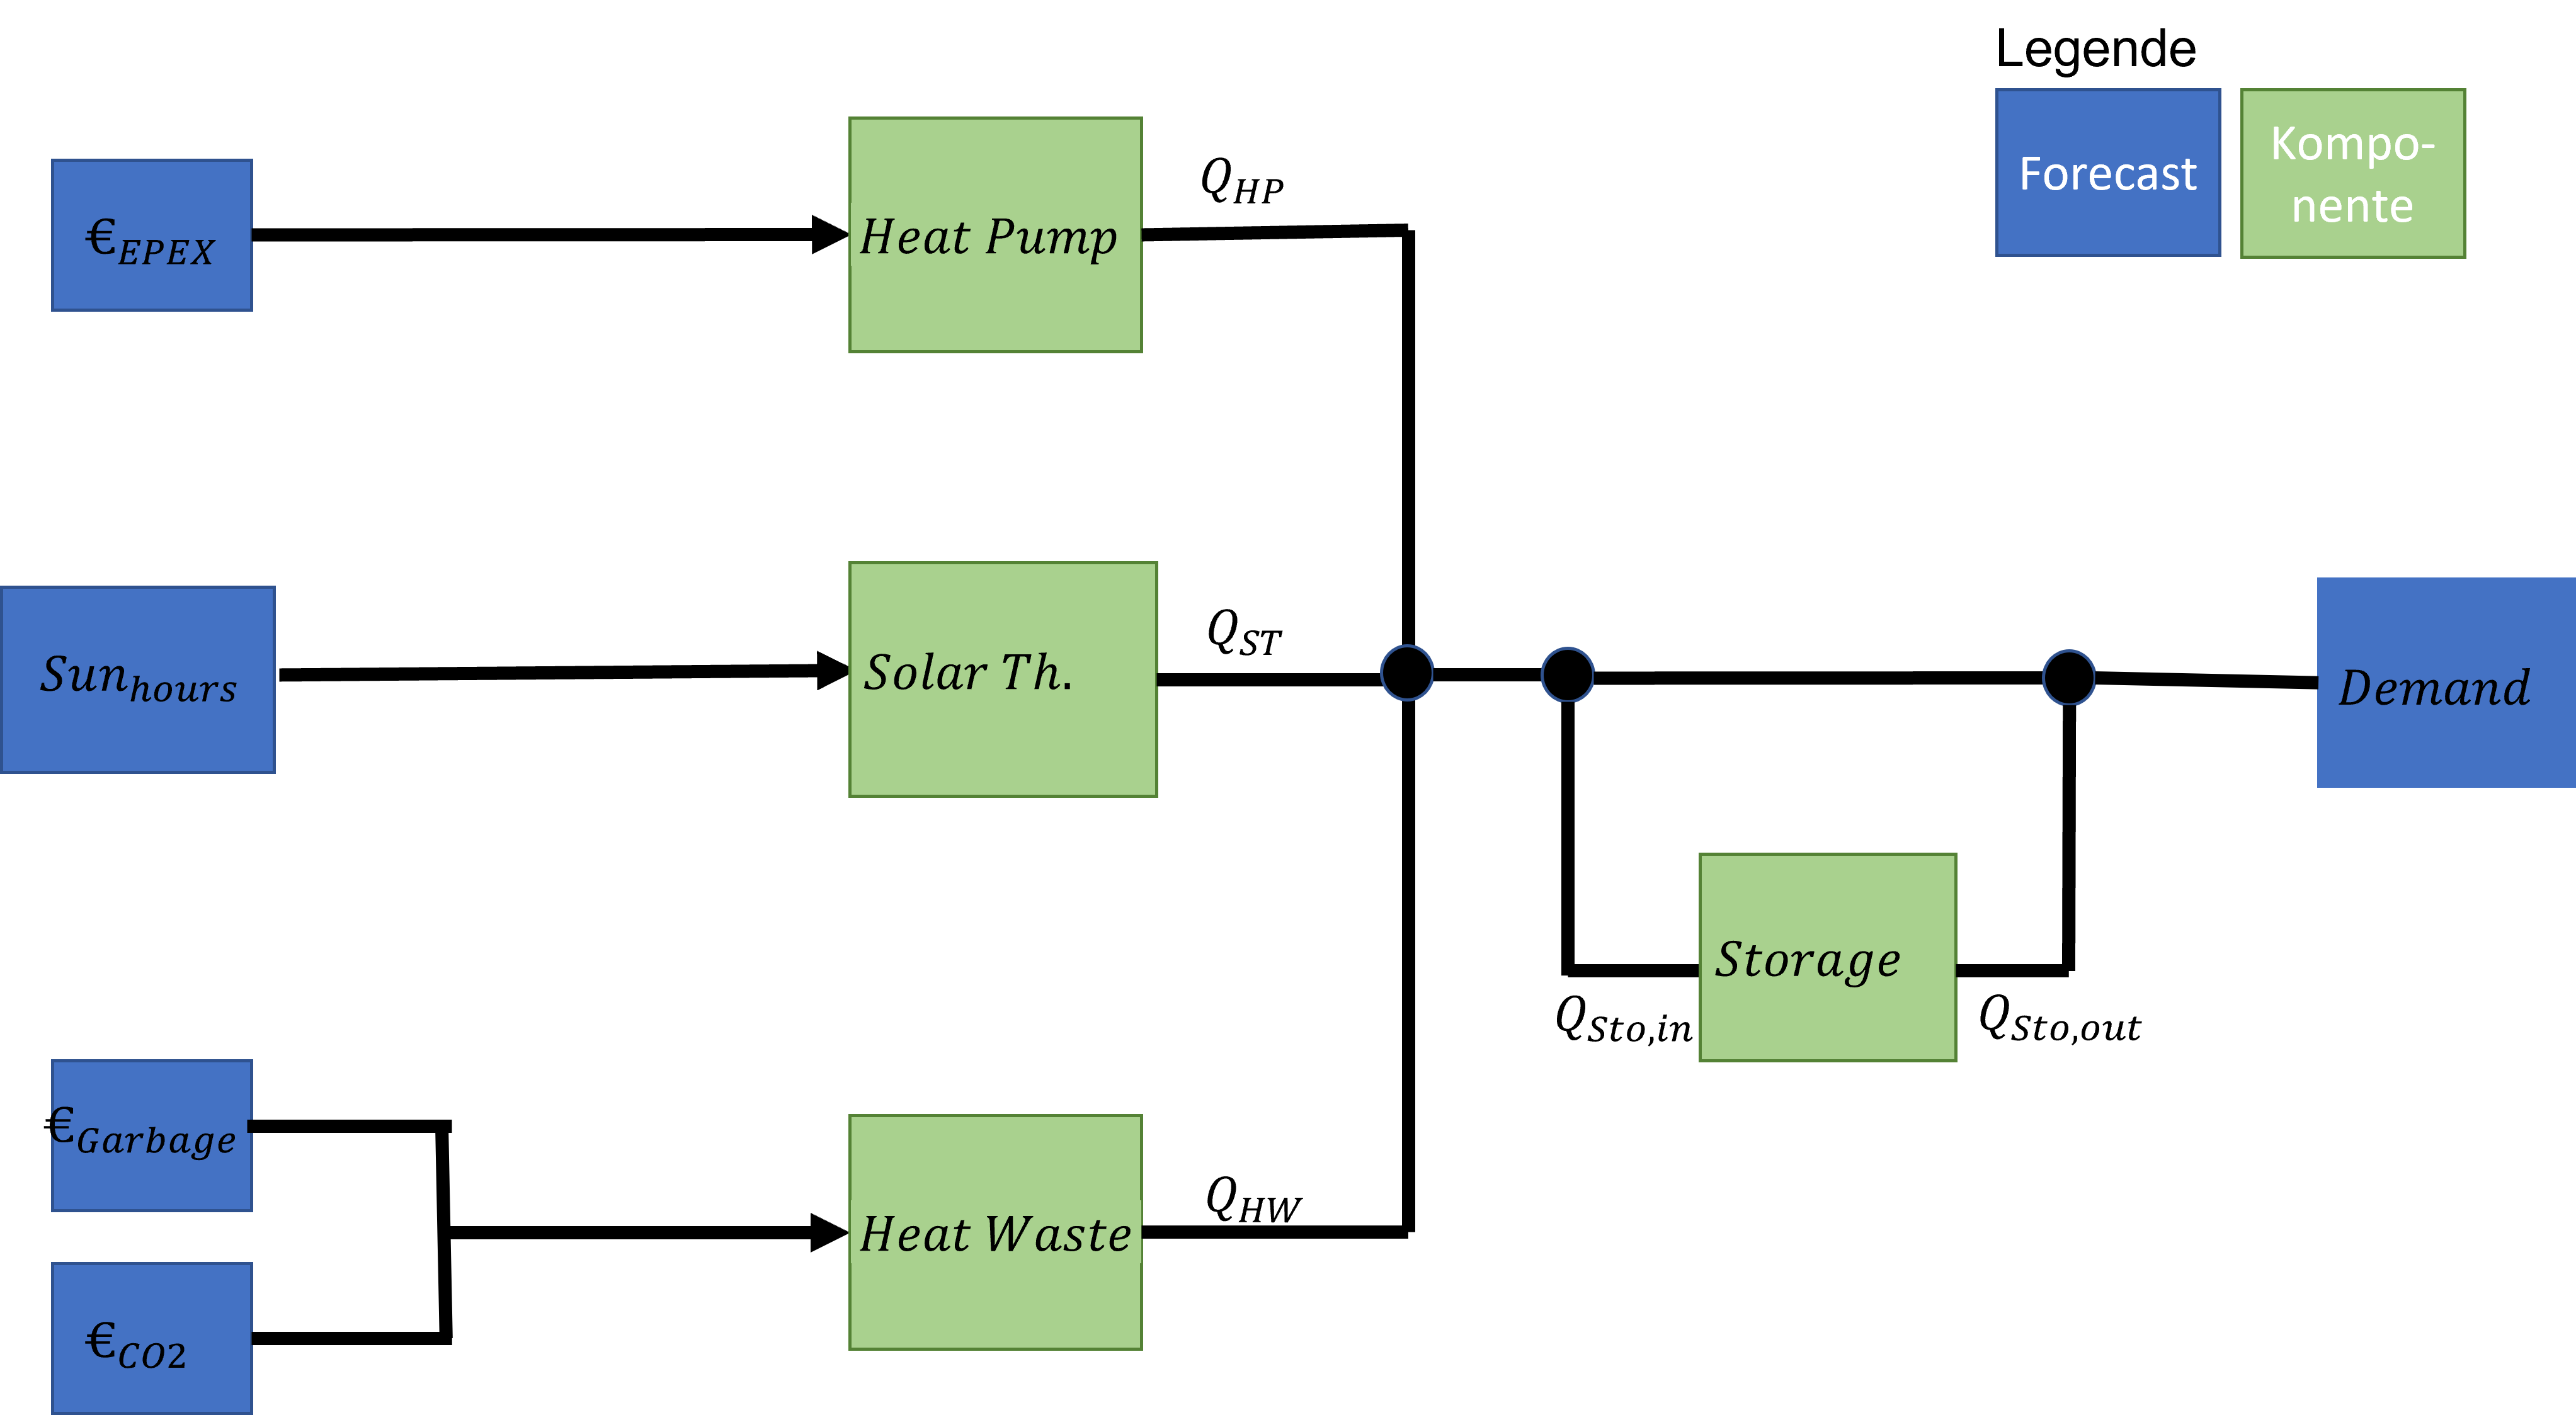

In [109]:
Image(filename=path_base+"/Modell.png")

## Exkurs: Forecasting Timeseries

In [61]:
df_train=df_all['2020-01-01 00:00':'2020-12-29 23:00']['demand_cust']
df_test=df_all['2020-12-30 00:00':'2020-12-31 23:00']['demand_cust']

In [50]:
df_train.shape, df_test.shape

((8736,), (24,))

In [51]:
# auto_arima=auto_arima(df_train,
#                         seasonal=True,
#                         m=24,
#                         max_d=1,
#                         max_D=1,
#                         max_p=2,
#                         max_P=2,
#                         max_q=2,
#                         max_Q=2,
#                         information_criterion='aic',
#                         trace=True,
#                         error_action='ignore',
#                         stepwise=True,
#                         surpress_warnings=True)

In [52]:
#Best model (2,1,0)(2,0,0)
sarimax_model=SARIMAX(df_train,
                     order=(2,1,0),
                     seasonal_order=(2,0,0,24))

C:\Users\frost\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
C:\Users\frost\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [53]:
sarimax_results=sarimax_model.fit()

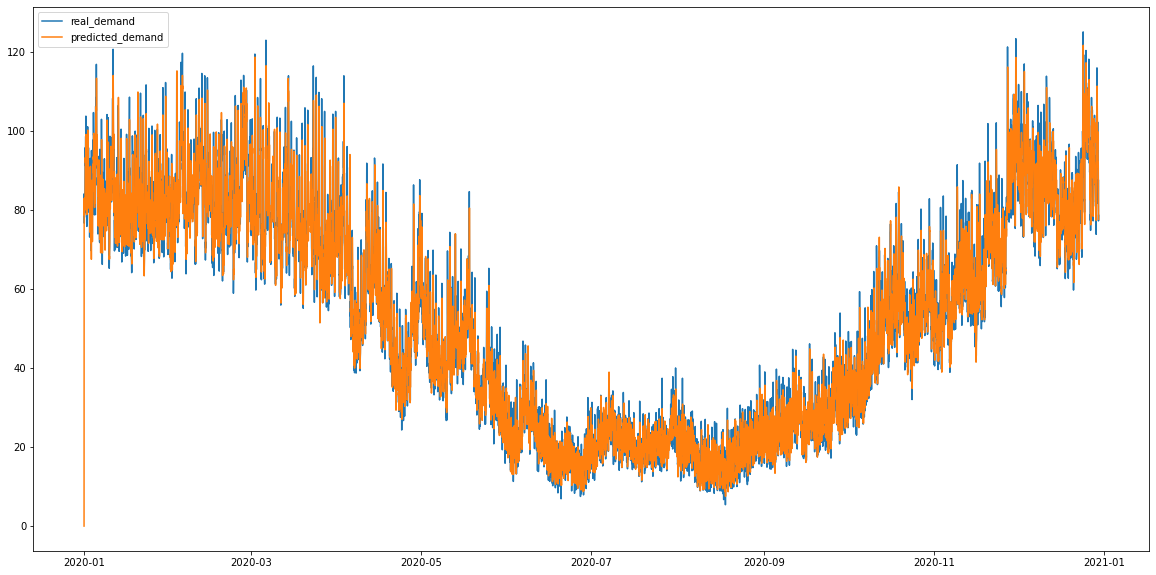

In [58]:
#In-Sample-Prediction
plt.plot(df_train,label='real_demand')
plt.plot(sarimax_results.predict(),label='predicted_demand');
plt.legend()
plt.show()

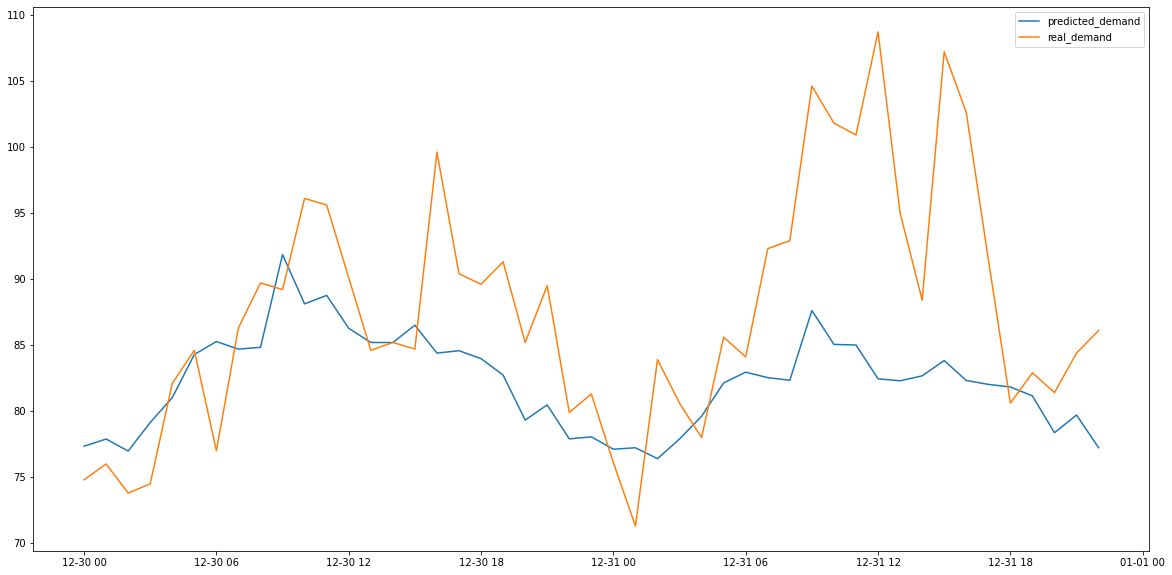

In [62]:
#Out-of-Sample Prediction
plt.plot(sarimax_results.forecast(steps=47,signal_only=False),label="predicted_demand")
plt.plot(df_test,label="real_demand")
plt.legend()
plt.show()

## 3.3 Prepare data

In [110]:
start='2018-01-08 00:00'
end='2018-01-14 23:00'
df_model=df_all[start:end]

In [111]:
df_EPEX=pd.read_excel(path_base+path_data+"Gro_handelspreise_201801080000_201801142359_Stunde.xlsx", header=9)
df_EPEX=df_EPEX[['DE/AT/LU [€/MWh]']]
df_EPEX_edit=df_EPEX.set_index(df_model.index)
df_model=pd.concat([df_model,df_EPEX_edit],axis=1)
df_model=df_model.rename(columns={"DE/AT/LU [€/MWh]":"EPEX_price"})

C:\Users\frost\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [112]:
df_model

,power_hp,power_solarthermic,power_waste_heat,power_solarthermic_edit,demand_cust,power_sum,EPEX_price
time_rounded,,,,,,,
2018-01-08 00:00:00+00:00,80.655246,56.522817,80.129808,0.0,108.1,160.785054,18.91
2018-01-08 01:00:00+00:00,65.805144,51.852937,86.758065,0.0,101.3,152.563209,15.15
2018-01-08 02:00:00+00:00,77.197798,1.363722,55.026260,0.0,107.4,132.224058,15.11
2018-01-08 03:00:00+00:00,74.199834,65.106759,85.999736,0.0,97.2,160.199570,13.42
2018-01-08 04:00:00+00:00,68.554687,35.358732,75.313188,0.0,104.2,143.867875,12.91
...,...,...,...,...,...,...,...
2018-01-14 19:00:00+00:00,83.227533,9.830997,78.708588,0.0,112.9,161.936121,34.72
2018-01-14 20:00:00+00:00,81.925459,74.829396,91.127091,0.0,115.6,173.052550,32.65
2018-01-14 21:00:00+00:00,74.211767,60.839800,79.935679,0.0,107.7,154.147447,30.42


## 3.4 define the Model

In [132]:
def solve_model(hs_charg_max, hs_ins_max, hs_outs_max):

    #Heat Pump
    hp_max=125 #kW heat max
    hp_eff=3 #kW heat / kW elec

    #solarthermic
    st_max=104 #kW heat max

    #Heat Waste
    hw_max=144 #kW heat max
    hw_cost_garbage=5 #Euro/kWh heat
    hw_cost_co2=5 #Euro/kWh heat

    #Peak generation
    peak=100 #kWh Heat 
    penalty=200 #€/kW above allowed peak generation
    
    
    #Instanciate the model
    model=ConcreteModel()
    
    
    #define index of model
    model.T=Set(initialize=RangeSet(len(df_model)),ordered=True)
    
    
    #Set parameters fix
    model.hp_max=Param(initialize=hp_max)
    model.hp_eff=Param(initialize=hp_eff)
    model.st_max=Param(initialize=st_max)
    model.hw_max=Param(initialize=hw_max)
    model.hw_cost_garbage=Param(initialize=hw_cost_garbage)
    model.hw_cost_co2=Param(initialize=hw_cost_co2)
    model.hs_charge_max=Param(initialize=hs_charg_max)
    model.hs_in_max=Param(initialize=hs_ins_max)
    model.hs_out_max=Param(initialize=hs_outs_max)
    model.peak=Param(initialize=peak)
    model.penalty=Param(initialize=penalty)
    
    #Set parameters time series
    model.sun_duration=Param(model.T,initialize=dict(enumerate(df_model["power_solarthermic_edit"],1)),within=Any) #sun duration for solartermic
    model.epex_spot=Param(model.T,initialize=dict(enumerate(df_model["EPEX_price"],1)),within=Any) #EPEX Spot prices
    
    
    #Set demand time series
    model.demand=Param(model.T,initialize=dict(enumerate(df_model["demand_cust"],1)),within=Any) #Heat demand of customers
    
    
    #Set Variables (with NonNegative Constraints included)
    model.hp=Var(model.T,  bounds = (0, model.hp_max)) #Heat generation of heat pump
    model.st=Var(model.T,  bounds = (0, model.st_max)) #Heat generation of solarthermic
    model.hw=Var(model.T,  bounds = (0, model.hw_max)) #Heat generation of heat waste plant
    model.hs_charge=Var(model.T,bounds=(0,model.hs_charge_max)) #Heat storage state
    model.hs_in=Var(model.T,  bounds = (0, model.hs_in_max)) #Heat flow IN storage
    model.hs_out=Var(model.T, bounds = (0, model.hs_out_max)) #Heat flow OUT of storage
    model.penalty_heat=Var(model.T,bounds=(0,None)) #Penalty costs if sum heat is > peak limit
    
    
    #Define Constraints
    
    #satifsy demand
    def satisfy_demand(model,t):
        return model.demand[t]==model.hp[t]+model.st[t]+model.hw[t]+model.hs_out[t]-model.hs_in[t]
    model.satisfy_demand = Constraint(model.T, rule = satisfy_demand)

    #State of heat storage
    def hs_constraint(model,t):
        if t == model.T.first():
            return model.hs_charge[t] == 0 #model.hs_charge_max/2
        else: 
            return model.hs_charge[t] == model.hs_charge[t-1] - model.hs_out[t-1] + model.hs_in[t-1]
    model.hs_constraint = Constraint(model.T, rule = hs_constraint)

    #max heat_out
    def hs_out_max(model,t):
        return model.hs_out[t]<=model.hs_charge[t]
    model.hs_out_max=Constraint(model.T,rule=hs_out_max)

    #limit st heat generation
    def st_running(model, t):
        # st cant run if no sunshine
        if model.sun_duration[t]<0.5:
            st_turn_on=0 #needs to be defined here since it´s no variable to be found by the solver!
        else:
            st_turn_on=1
        return model.st[t]<=st_turn_on*model.st_max #st generation is 0 if no sunshine or between 0 and st_max if sunshine
    model.st_running_con = Constraint(model.T, rule=st_running)
    
    #punish if heat generation above limit
    def punish_peak(model,t):
        return model.penalty_heat[t]>=model.hp[t]+model.st[t]+model.hw[t]-model.peak #if <0 --> penalty_peak=0
    model.punish_peak=Constraint(model.T,rule=punish_peak)
    
    
    #Objective Function (minimize costs)
    expr=sum((model.hp[t]/model.hp_eff)*model.epex_spot[t] + model.st[t]*0 + model.hw[t]*(model.hw_cost_garbage+model.hw_cost_co2) \
         +model.penalty_heat[t]*model.penalty for t in model.T)
    model.objective=Objective(expr=expr,sense=minimize) #Minimize Cost-Funtion (expr)
    
    return model

## 3.5 Solution without Storage - STATUS QUO

In [116]:
#Heat Storage
hs_charge_max=0 #kWh storage volume max
hs_in_max=0 #kW storage IN max
hs_out_max=0 #kW storage OUT max

In [117]:
model_wo_storage=solve_model(hs_charge_max,hs_in_max,hs_out_max)

    'pyomo.core.base.param.ScalarParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().


In [118]:
solver = SolverFactory('glpk')
results_wo_storage = solver.solve(model_wo_storage)

In [120]:
print(results_wo_storage)


Problem: 
- Name: unknown
  Lower bound: 288569.517
  Upper bound: 288569.517
  Number of objectives: 1
  Number of constraints: 841
  Number of variables: 1177
  Number of nonzeros: 2686
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.10423517227172852
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## 3.6 Solution with Storage - Improvement

In [121]:
#Heat Storage
hs_charge_max=200 #kWh storage volume max
hs_in_max=20 #kW storage IN max
hs_out_max=20 #kW storage OUT max

In [122]:
model_storage=solve_model(hs_charge_max,hs_in_max,hs_out_max)

    'pyomo.core.base.param.ScalarParam'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.constraint.IndexedConstraint'>).
    This is usually indicative of a modelling error. To avoid this warning,
    use block.del_component() and block.add_component().


In [123]:
solver = SolverFactory('glpk')
results_storage = solver.solve(model_storage)

In [124]:
print(results_storage)


Problem: 
- Name: unknown
  Lower bound: 207806.170333333
  Upper bound: 207806.170333333
  Number of objectives: 1
  Number of constraints: 841
  Number of variables: 1177
  Number of nonzeros: 2686
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.10597634315490723
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



## 3.7 Comparison "without storage vs. storage"

In [125]:
print(f'Total costs for optimization WITHOUT Storage:  {results_wo_storage["Problem"][0]["Lower bound"]:,}\n\
Total costs for optimization WITH Storage:  {results_storage["Problem"][0]["Lower bound"]:,}')

Total costs for optimization WITHOUT Storage:  288,569.517
Total costs for optimization WITH Storage:  207,806.170333333


In [126]:
cols_wo_storage = []
cols_wo_storage.append(pd.Series(model_wo_storage.hp.extract_values(), name='heat_pump_heat'))
cols_wo_storage.append(pd.Series(model_wo_storage.hw.extract_values(), name='heat_waste_heat'))
cols_wo_storage.append(pd.Series(model_wo_storage.st.extract_values(), name='st_heat'))
cols_wo_storage.append(pd.Series(model_wo_storage.sun_duration.extract_values(), name='sun_duration'))
cols_wo_storage.append(pd.Series(model_wo_storage.hs_charge.extract_values(), name='hs_charge'))
cols_wo_storage.append(pd.Series(model_wo_storage.hs_in.extract_values(), name='hs_in'))
cols_wo_storage.append(pd.Series(model_wo_storage.hs_out.extract_values(), name='hs_out'))
cols_wo_storage.append(pd.Series(model_wo_storage.epex_spot.extract_values(), name='epex_spot'))
cols_wo_storage.append(pd.Series(model_wo_storage.demand.extract_values(), name='demand'))
cols_wo_storage.append(pd.Series(model_wo_storage.penalty_heat.extract_values(), name='penalty_heat'))
df_results_wo_storage = pd.concat(cols_wo_storage, axis=1)
df_results_wo_storage=df_results_wo_storage.set_index(df_model.index)

df_results_wo_storage['heat_sum']=df_results_wo_storage['heat_pump_heat']+df_results_wo_storage['heat_waste_heat']+df_results_wo_storage['st_heat']

In [128]:
df_results_wo_storage.tail(24)

,heat_pump_heat,heat_waste_heat,st_heat,sun_duration,hs_charge,hs_in,hs_out,epex_spot,demand,penalty_heat,heat_sum
time_rounded,,,,,,,,,,,
2018-01-14 00:00:00+00:00,100.5,0.0,0.0,0.000000,0.0,0.0,0.0,23.25,100.5,0.5,100.5
2018-01-14 01:00:00+00:00,98.0,0.0,0.0,0.000000,0.0,0.0,0.0,22.82,98.0,0.0,98.0
2018-01-14 02:00:00+00:00,96.6,0.0,0.0,0.000000,0.0,0.0,0.0,24.01,96.6,0.0,96.6
2018-01-14 03:00:00+00:00,99.2,0.0,0.0,0.000000,0.0,0.0,0.0,22.37,99.2,0.0,99.2
2018-01-14 04:00:00+00:00,102.1,0.0,0.0,0.000000,0.0,0.0,0.0,22.35,102.1,2.1,102.1
2018-01-14 05:00:00+00:00,103.6,0.0,0.0,0.000000,0.0,0.0,0.0,21.66,103.6,3.6,103.6
2018-01-14 06:00:00+00:00,105.8,0.0,0.0,0.000000,0.0,0.0,0.0,20.45,105.8,5.8,105.8
2018-01-14 07:00:00+00:00,0.0,0.0,103.8,18.876564,0.0,0.0,0.0,22.02,103.8,3.8,103.8
2018-01-14 08:00:00+00:00,3.4,0.0,104.0,65.114971,0.0,0.0,0.0,28.09,107.4,7.4,107.4


- heat generation == demand in every hour
- penalty heat shows up if demand>penalty_limit

In [129]:
cols_storage = []
cols_storage.append(pd.Series(model_storage.hp.extract_values(), name='heat_pump_heat'))
cols_storage.append(pd.Series(model_storage.hw.extract_values(), name='heat_waste_heat'))
cols_storage.append(pd.Series(model_storage.st.extract_values(), name='st_heat'))
cols_storage.append(pd.Series(model_storage.sun_duration.extract_values(), name='sun_duration'))
cols_storage.append(pd.Series(model_storage.hs_charge.extract_values(), name='hs_charge'))
cols_storage.append(pd.Series(model_storage.hs_in.extract_values(), name='hs_in'))
cols_storage.append(pd.Series(model_storage.hs_out.extract_values(), name='hs_out'))
cols_storage.append(pd.Series(model_storage.epex_spot.extract_values(), name='epex_spot'))
cols_storage.append(pd.Series(model_storage.demand.extract_values(), name='demand'))
cols_storage.append(pd.Series(model_storage.penalty_heat.extract_values(), name='penalty_heat'))
df_results_storage = pd.concat(cols_storage, axis=1)
df_results_storage=df_results_storage.set_index(df_model.index)

df_results_storage['heat_sum']=df_results_storage['heat_pump_heat']+df_results_storage['heat_waste_heat']+df_results_storage['st_heat']

In [130]:
df_results_storage.tail(24)

,heat_pump_heat,heat_waste_heat,st_heat,sun_duration,hs_charge,hs_in,hs_out,epex_spot,demand,penalty_heat,heat_sum
time_rounded,,,,,,,,,,,
2018-01-14 00:00:00+00:00,106.8,0.0,0.0,0.000000,60.6,6.3,0.0,23.25,100.5,6.8,106.8
2018-01-14 01:00:00+00:00,118.0,0.0,0.0,0.000000,66.9,20.0,0.0,22.82,98.0,18.0,118.0
2018-01-14 02:00:00+00:00,100.0,0.0,0.0,0.000000,86.9,3.4,0.0,24.01,96.6,0.0,100.0
2018-01-14 03:00:00+00:00,119.2,0.0,0.0,0.000000,90.3,20.0,0.0,22.37,99.2,19.2,119.2
2018-01-14 04:00:00+00:00,122.1,0.0,0.0,0.000000,110.3,20.0,0.0,22.35,102.1,22.1,122.1
2018-01-14 05:00:00+00:00,123.6,0.0,0.0,0.000000,130.3,20.0,0.0,21.66,103.6,23.6,123.6
2018-01-14 06:00:00+00:00,125.0,0.0,0.0,0.000000,150.3,19.2,0.0,20.45,105.8,25.0,125.0
2018-01-14 07:00:00+00:00,19.8,0.0,104.0,18.876564,169.5,20.0,0.0,22.02,103.8,23.8,123.8
2018-01-14 08:00:00+00:00,0.0,0.0,104.0,65.114971,189.5,0.0,3.4,28.09,107.4,4.0,104.0


- heat generation != demand in every hour --> load and demand shifted to or from storage is possible!
- less penalty_heat

In [134]:
print(f'Penalty costs WITHOUT heat storage: {round(df_results_wo_storage["penalty_heat"].sum()*200,1):,}\n\
Penalty costs WITH heat storage: {round(df_results_storage["penalty_heat"].sum()*200,1):,}')

Penalty costs WITHOUT heat storage: 191,500.0
Penalty costs WITH heat storage: 113,500.0


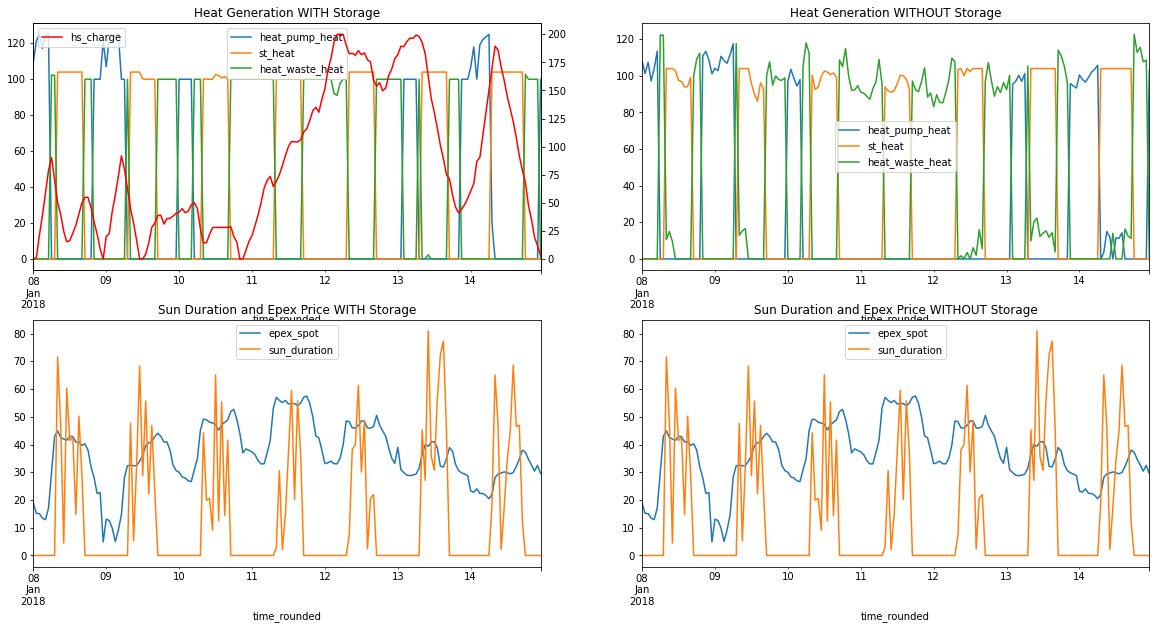

In [135]:
#plot relevant data
fig,axs=plt.subplots(2,2)
ax1=df_results_storage[['heat_pump_heat','st_heat','heat_waste_heat']].plot(legend=True, title="Heat Generation WITH Storage",ax=axs[0,0])
ax2=ax1.twinx()
df_results_storage['hs_charge'].plot(ax=ax2,legend=True,color='red');
df_results_wo_storage[['heat_pump_heat','st_heat','heat_waste_heat']].plot(legend=True, title="Heat Generation WITHOUT Storage",ax=axs[0,1]);
df_results_storage[['epex_spot','sun_duration']].plot(legend=True, title="Sun Duration and Epex Price WITH Storage",ax=axs[1,0]);
df_results_wo_storage[['epex_spot','sun_duration']].plot(legend=True, title="Sun Duration and Epex Price WITHOUT Storage",ax=axs[1,1]);

- in times of low epex spot prices the storage is loaded --> shifting heat generation 
- peak shifting since storage provides heat in high-demand-hours
- st heat in both scenarios just during sun-duration-hours

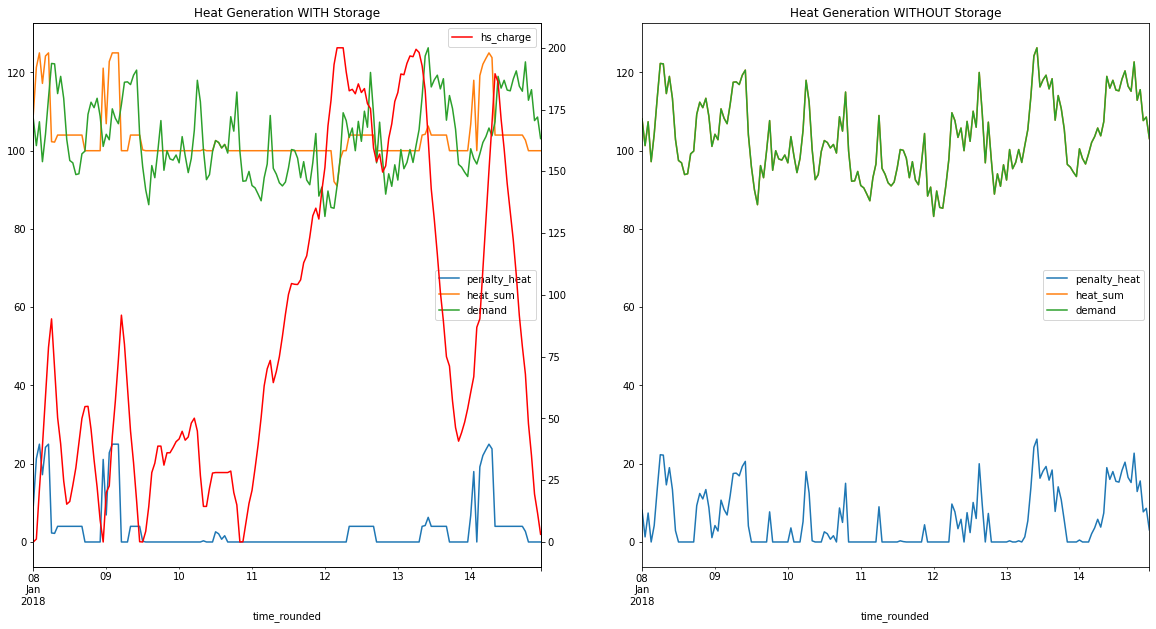

In [286]:
#plot relevant data
fig,axs=plt.subplots(ncols=2)
ax1=df_results_storage[['penalty_heat','heat_sum','demand']].plot(legend=True, title="Heat Generation WITH Storage",ax=axs[0]);
ax2=ax1.twinx()
df_results_storage['hs_charge'].plot(ax=ax2,legend=True,color='red');
df_results_wo_storage[['penalty_heat','heat_sum','demand']].plot(legend=True, title="Heat Generation WITHOUT Storage",ax=axs[1]);


- penalty heat is difference between heat_sum - 100
- wo_storage scenario: heat_sum (orange) == demand (green) --> no possibility to avoid penalty heat!
- storage scenario: 
    - heat_sum > demand --> store heat for high-time-prices, could lead to penalty heat
    - heat_sum < demand --> take heat out of storage during high-time-prices, avoids penalt heat
    - -->in total less penalty heat than wo_storage_scenario


# 4. Notes

- Stichworte:
    - Drei-Wege-Mischer
        - Netz wird mit festgelegter TEmperatur gefahren
        - alle Einspeiser sind allerdings individuell: entweder Orientierung an Netz-Temperatur (vllt dann aebr nicht optimal für Einspeiser) oder wenn Vorlauf aus Einspeiser zu hoch, dann Mischung über 3 Wege-Mischer mit Rücklauf --> abkühlen!
        - höherer VL von Einspeisern ggüber Netz auch dahingehend sinnvoll, dass eventueller Überschuss in Speicehr gefahren wird --> je höher Speicher-VL desto mehr Wärme gespeichert
    - iHast
    - unterschiedliche Vorlauf bzw Rücklauftemperaturen
        - Vorlauf: höher je weiter "vorn" Kunde am FW-Netz hängt
        - Rücklauf: Kunden die weniger "ziehen" speisen höheren Rücklauf zurück ins Netz
    - grundsätzlich: je niedriger Rücklauf, desto mehr im Speicher und desto effizienter arbeitet WP, da sie von niedrigerem Niveau auf Spreizung kommen muss